0.9471044405046498
0.7636769986824598
[epoch 1, iter    10] loss: 0.082 eplased time 0.025
[epoch 1, iter    20] loss: 0.112 eplased time 0.025
[epoch 1, iter    30] loss: 0.082 eplased time 0.025
[epoch 2, iter    10] loss: 0.084 eplased time 0.024
[epoch 2, iter    20] loss: 0.080 eplased time 0.024
[epoch 2, iter    30] loss: 0.082 eplased time 0.024
[epoch 3, iter    10] loss: 0.061 eplased time 0.024


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


[epoch 3, iter    20] loss: 0.088 eplased time 0.027
[epoch 3, iter    30] loss: 0.088 eplased time 0.027
[epoch 4, iter    10] loss: 0.079 eplased time 0.033
[epoch 4, iter    20] loss: 0.080 eplased time 0.032
[epoch 4, iter    30] loss: 0.077 eplased time 0.037
[epoch 5, iter    10] loss: 0.083 eplased time 0.050
[epoch 5, iter    20] loss: 0.078 eplased time 0.052
[epoch 5, iter    30] loss: 0.073 eplased time 0.061
[epoch 6, iter    10] loss: 0.093 eplased time 0.064
[epoch 6, iter    20] loss: 0.073 eplased time 0.046
[epoch 6, iter    30] loss: 0.080 eplased time 0.042
[epoch 7, iter    10] loss: 0.084 eplased time 0.047
[epoch 7, iter    20] loss: 0.080 eplased time 0.038
[epoch 7, iter    30] loss: 0.077 eplased time 0.038
[epoch 8, iter    10] loss: 0.079 eplased time 0.035
[epoch 8, iter    20] loss: 0.074 eplased time 0.034
[epoch 8, iter    30] loss: 0.082 eplased time 0.045
[epoch 9, iter    10] loss: 0.073 eplased time 0.040
[epoch 9, iter    20] loss: 0.070 eplased time

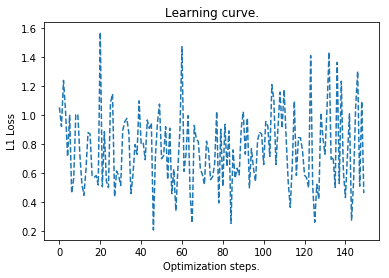

In [63]:
import numpy as np
import torch
import torch.utils.data as data_utils
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import math
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error


#Takes in csv file and loads it so that it is a pytorch tensor for training and testing data
def loader(full=True, RMP=False):
	X_train, y_train, X_test, y_test = None, None, None, None

	#Read csv file and drop unncecessary columns
	data = pd.read_csv('updated_years_of_employment.csv')
	data = data.drop(['LAST','FIRST','UID','MIDDLE','APPT FRACTION','AMT OF SALARY PAID FROM GENL FUND',
		'FOS', 'Field14', 'url', 'X1', 'found'], axis=1)
	data.replace(["NaN", 'N/A', '--', '', np.nan], 'NA', inplace = True)
	#Get number of unique values
	columns = list(data.columns.values)
	unique_vals_set = set()
	for i in columns:
		if i != 'APPT ANNUAL FTR':
			unique_vals_set.update(set(data[i].unique().tolist()))
	unique_vals = len(unique_vals_set)

	unique_vals_list = list(unique_vals_set)

	index = 1
	dictionary = {'NaN':0}
	for index, val in enumerate(unique_vals_list):
		if val not in dictionary:
			dictionary[unique_vals_list[index]] = index
			index += 1

	data = data.replace(dictionary)

	if full:
		#Turn data to numpy array
		data = data.values
		#Full dataset variables of X and Y
		y_vals = data[:, 17]
		X_vals = np.delete(data, 17, axis=1)
	elif RMP:
		data = data[['quality', 'difficulty', 'wtapercent', 'reviews', 'APPT ANNUAL FTR']]
		#Turn data to numpy array
		data = data.values
		#Full dataset variables of X and Y
		y_vals = data[:, 4]
		X_vals = data[:, :4]
	else:
		data = data[['APPOINTMENT TITLE', 'APPT FTR BASIS', 'citations', 'Service Dt', 'APPT ANNUAL FTR']]
		#Turn data to numpy array
		data = data.values
		#Full dataset variables of X and Y
		y_vals = data[:, 4]
		X_vals = data[:, :4]



	indices = np.random.permutation(y_vals.shape[0])
	training_idx = indices[:math.floor(y_vals.shape[0] * 0.8)], 
	test_idx = indices[math.floor(y_vals.shape[0] * 0.8):math.floor(y_vals.shape[0] * 0.9)]
	val_idx = indices[math.floor(y_vals.shape[0] * 0.9):]
	
	X_train = X_vals[training_idx, :]
	X_test = X_vals[test_idx,:]
	y_train = y_vals[training_idx]
	y_test = y_vals[test_idx]
	X_validate = X_vals[val_idx, :]
	y_validate = y_vals[val_idx]

	#np.reshape(X_train, (173,1))
	X_train = X_train.reshape(-1, X_train.shape[-1])

	y_mean = np.mean(y_train)
	y_sd = math.sqrt(np.var(y_train))

	y_train = (y_train - y_mean) / y_sd
	y_test = (y_test - y_mean) / y_sd
	y_validate = (y_validate - y_mean) / y_sd

	return X_train, y_train, X_test, y_test, X_validate, y_validate, unique_vals


#Our Model's class
class NeuralNet(nn.Module):
	def __init__(self, embed_units, hidden_units1=50, hidden_units2=100, output_units=1, inp_units=20):
		super().__init__()

		#Change these to our liking. Maybe add Batchnorm or L2 Normalization?
		#Also maybe do weight initialization ourselves?

		self.embed = nn.Embedding(embed_units, 20) #Figure out how we want to do embedding
		self.fc = nn.Sequential(
			# N x ? tensor (? WILL BE KNOWN ONCE EMBEDDING HAS BEEN IMPLEMENTED)
			nn.Linear(20, hidden_units1),
			nn.LeakyReLU(negative_slope=.5, inplace=True),
			nn.BatchNorm1d(18),
			nn.Dropout(0.2),
			# N x 100 tensor
			nn.Linear(hidden_units1, hidden_units2),
			nn.LeakyReLU(negative_slope=.5, inplace=True),
			nn.BatchNorm1d(18),
			nn.Dropout(0.1),
			# N x 200 tensor
			nn.Linear(hidden_units2, hidden_units1),
			nn.Tanh(),
			# N x 100 tensor
			nn.Linear(hidden_units1,output_units),
			nn.Tanh()
			# N x 1 tensor
			)


	def forward(self, x):
		# x is an N x dim tensor
		y_hat = self.embed(x.long()) #Add the embedding once figured out
		y_hat = self.fc(y_hat) 
		return y_hat

#Set weights of model
def init_weights(m):
	if type(m) == nn.Linear:
		torch.nn.init.xavier_uniform(m.weight)
		m.bias.data.fill_(0.01)

def NeuralTrain(trainloader, net, criterion, optimizer, device):
	loss_graph = []
	for epoch in range(50):  # loop over the dataset for x number of epochs
		start = time.time()
		running_loss = 0.0

		#For each batch run through model, backprop, and optimize weights
		for i, (data, salary) in enumerate(trainloader):
			data = data.to(device).float()
			salary = salary.to(device).float()

			optimizer.zero_grad()
			output = net(data)
			loss = criterion(output, salary)
			loss.backward()
			optimizer.step()

			# print statistics
			running_loss += loss.item()
			
			if i % 10 == 9:
				loss_graph.append(loss.item())
				end = time.time()
				print('[epoch %d, iter %5d] loss: %.3f eplased time %.3f' % 
					(epoch + 1, i + 1, running_loss / 100, end - start))
				start = time.time()
				running_loss = 0.0
    
	# Plot learning curve
	fig1, ax1 = plt.subplots()
	ax1.plot(loss_graph, '--')
	ax1.set_title('Learning curve.')
	ax1.set_ylabel('L1 Loss')
	ax1.set_xlabel('Optimization steps.')

	print('Finished Training')

def NeuralTest(testloader, net, criterion, device):
	total = 0
	error = []
	#fig2, ax2 = plt.subplots()
	with torch.no_grad():
		for data in testloader:
			representations, salary = data
			representations = representations.to(device).float()
			salary = salary.to(device).float()
			outputs = net(representations)
			loss = criterion(outputs, salary)
			'''
			ax2.plot(outputs.numpy(), salary.numpy(), 'r+')
			ax2.set_title('Prediction Plot')
			ax2.set_ylabel('Actual Salary')
			ax2.set_xlabel('Prediction')
			'''
			error.append(loss)
	print('Error: %s dollars' % (np.mean(error)))

def main():
	#Sets device to cpu or gpu if you have one
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	#Get our datasets loaded
	X_train, y_train, X_test, y_test, X_validate, y_validate, unique_vals = loader(False, True)

	#Base model
	knn = KNeighborsRegressor(n_neighbors=5)
	knn.fit(X_train, y_train)
	y_test_pred = knn.predict(X_test)
	y_valid_pred = knn.predict(X_validate)

	print(mean_absolute_error(y_test, y_test_pred))
	print(mean_absolute_error(y_validate, y_valid_pred))


	#Turn numpy matrices into pytorch tensors for neural network
	X_train = torch.tensor(X_train.astype(dtype = 'float32'))
	y_train = torch.tensor(y_train.astype(dtype = 'float32'))
	X_test = torch.tensor(X_test.astype(dtype = 'float32'))
	y_test = torch.tensor(y_test.astype(dtype = 'float32'))
	X_validate = torch.tensor(X_validate.astype(dtype = 'float32'))
	y_validate = torch.tensor(y_validate.astype(dtype = 'float32'))

	#Put them into torch datasets with batch size 
	#BATCH SIZE CAN CHANGE TO WHATEVER WORKS BEST
	trainset = data_utils.TensorDataset(X_train, y_train)
	trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)

	testset = data_utils.TensorDataset(X_test, y_test)
	testloader = torch.utils.data.DataLoader(testset, batch_size=y_test.shape[0], shuffle=False)

	validset = data_utils.TensorDataset(X_validate, y_validate)
	validloader = torch.utils.data.DataLoader(validset, batch_size=y_validate.shape[0], shuffle=False)

	#Model and Loss
	net = NeuralNet(embed_units=unique_vals).to(device)
	net.apply(init_weights)
	criterion = nn.L1Loss()

	#Can also switch from adam to sgd if we so choose
	optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

	#Train, Test, and Validate model
	NeuralTrain(trainloader, net, criterion, optimizer, device)
	NeuralTest(testloader, net, criterion, device)
	NeuralTest(validloader, net, criterion, device)



if __name__ == '__main__':
	main()


























